In [6]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import _tree, DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb



In [3]:
df = pd.read_csv('pca2.csv')
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE
0,2023000000009,1,3600,19,1,19,2,16,1,7220,8,2,8680,4055,3,3,0
1,2023000000028,1,800,23,1,19,1,15,1,7115,1,1,8564,2850,3,3,1
2,2023000000052,1,1800,23,1,20,1,15,1,7115,1,1,8564,2850,3,3,1
3,2023000000125,1,65000,28,1,19,1,40,6,4492,9,2,4796,4760,3,3,0
4,2023000000152,1,3000,20,1,19,2,20,6,61101,2,1,7870,4640,3,3,2


In [ ]:
df2 = df.drop(['SERIALNO','SPORDER', 'NAICSP','RAC1P','HISP'], axis=1)


print('Shape of filtered data:', df2.shape)
print(df2.dtypes)

df=df2

Shape of filtered data: (186375, 12)
WAGP         int64
AGEP         int64
COW          int64
SCHL         int64
SEX          int64
WKHP         int64
ESR          int64
INDP         int64
OCCP         int64
SCIENGP      int64
SCIENGRLP    int64
RACE         int64
dtype: object


# Outlier Removal Function

In [5]:
def remove_outliers_by_group(df, target_col, group_cols):
    """
    Calculates IQR for a target column grouped by other columns and removes outliers.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the column to calculate IQR for.
        group_cols (list): A list of column names to group by.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """

    # Calculate Q1, Q3, and IQR for each group
    q1 = df.groupby(group_cols)[target_col].quantile(0.25)
    q3 = df.groupby(group_cols)[target_col].quantile(0.75)
    iqr = q3 - q1

    # Define upper and lower bounds for outlier detection
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Merge bounds back into the original DataFrame
    df_with_bounds = pd.merge(df, lower_bound.rename('lower_bound'), left_on=group_cols, right_index=True)
    df_with_bounds = pd.merge(df_with_bounds, upper_bound.rename('upper_bound'), left_on=group_cols, right_index=True)

    # Filter out outliers
    filtered_df = df_with_bounds[(df_with_bounds[target_col] >= df_with_bounds['lower_bound']) & (df_with_bounds[target_col] <= df_with_bounds['upper_bound'])]

    # Remove temporary bound columns
    filtered_df = filtered_df.drop(columns=['lower_bound', 'upper_bound'])

    return filtered_df


group_columns = ['SCHL', 'SEX']
target_column = 'WAGP'

df_clean = remove_outliers_by_group(df2, target_column, group_columns)
df_clean.shape

(178974, 12)

# XGB LGBM Blended Model

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP']  # Apply log transformation
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  
    learning_rate=0.005,  
    max_depth=9,  
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction (adjust weights based on performance)
y_pred_blended = (0.6 * y_pred_xgb) + (0.4 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
Blended Model R-squared Score: 0.6257


# adjust loss function

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP']  # Apply log transformation
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  # More trees for better learning
    learning_rate=0.005,  
    max_depth=9,  # Deeper trees to capture interactions
    min_child_weight=3,  
    colsample_bytree=0.9,  # Uses 90% of features per tree to improve diversity
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    objective = 'huber',
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction (adjust weights based on performance)
y_pred_blended = (0.6 * y_pred_xgb) + (0.4 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
Blended Model R-squared Score: 0.5259


# refinement

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP']  # Apply log transformation
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
# Outlier Removal
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
X_train = X_train[(z_scores < 3).all(axis=1)]
y_train = y_train[(z_scores < 3).all(axis=1)]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(
    n_estimators=5000,  # More trees for better learning
    learning_rate=0.005,  # Lower LR for better generalization
    max_depth=9,  
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05, 
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Blended prediction (adjust weights based on performance)
y_pred_blended = (0.5 * y_pred_xgb) + (0.5 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 131204, number of used features: 14
[LightGBM] [Info] Start training from score 62370.559480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

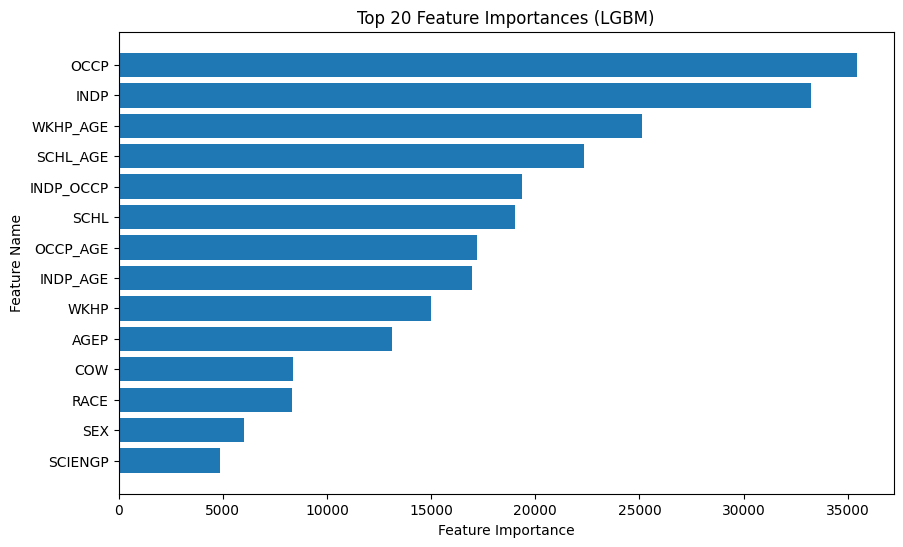

In [ ]:
# Feature Importance from LGBM
importance = lgbm_model.feature_importances_
features = X_train.columns

sorted_idx = np.argsort(importance)[::-1]  # Sort in descending order
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx][:20], importance[sorted_idx][:20])  
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances (LGBM)")
plt.gca().invert_yaxis()
plt.show()


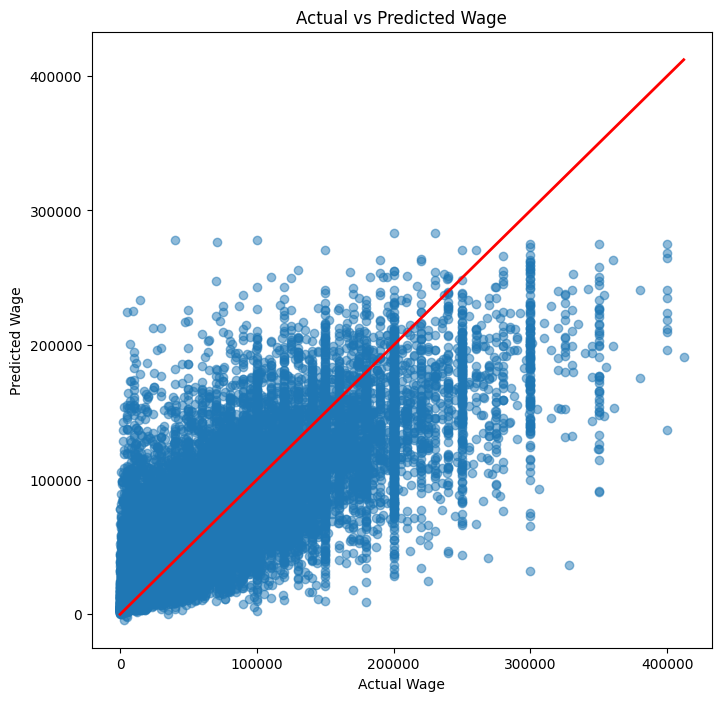

In [ ]:
#Plotting Actual vs Predicted Wage
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_blended, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linewidth=2)  
plt.xlabel("Actual Wage")
plt.ylabel("Predicted Wage")
plt.title("Actual vs Predicted Wage")
plt.show()


# Log transform Y to handle high wage

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP']  # Apply log transformation
y_log = np.log1p(dfStack['WAGP'])
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=1234
)
# Outlier Removal
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
X_train = X_train[(z_scores < 3).all(axis=1)]
y_train = y_train[(z_scores < 3).all(axis=1)]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(
    n_estimators=5000,  # More trees for better learning
    learning_rate=0.005,  # Lower LR for better generalization
    max_depth=9,  # Deeper trees to capture interactions
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8, 
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train_scaled, y_train)
lgbm_model.fit(X_train_scaled, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Blended prediction
y_pred_blended = (0.5 * y_pred_xgb) + (0.5 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 131204, number of used features: 14
[LightGBM] [Info] Start training from score 10.548742
Blended Model R-squared Score: 0.5812


# Log transform didnt help. Apply Polynomial Transformation

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP']  # Apply log transformation
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Outlier Removal
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
X_train = X_train[(z_scores < 3).all(axis=1)]
y_train = y_train[(z_scores < 3).all(axis=1)]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
xgb_model = XGBRegressor(
    n_estimators=5000,  # More trees for better learning
    learning_rate=0.005,  # Lower LR for better generalization
    max_depth=9,  # Deeper trees to capture interactions
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05, 
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train_poly, y_train)
lgbm_model.fit(X_train_poly, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test_poly)
y_pred_lgbm = lgbm_model.predict(X_test_poly)

# Blended prediction 
y_pred_blended = (0.5 * y_pred_xgb) + (0.5 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22317
[LightGBM] [Info] Number of data points in the train set: 131204, number of used features: 105
[LightGBM] [Info] Start training from score 62370.559480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Blended Model R-squared Score: 0.6171


In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate LGBM with Polynomial Features
r2_poly = r2_score(y_test, y_pred_blended)
mae_poly = mean_absolute_error(y_test, y_pred_blended)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_blended))

# Compare with the Original Model
r2_original = r2_score(y_test, y_pred_lgbm)
mae_original = mean_absolute_error(y_test, y_pred_lgbm)
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print(f"Original Model R²: {r2_original:.4f}, MAE: {mae_original:.2f}, RMSE: {rmse_original:.2f}")
print(f"Polynomial Model R²: {r2_poly:.4f}, MAE: {mae_poly:.2f}, RMSE: {rmse_poly:.2f}")


Original Model R²: 0.6137, MAE: 23248.66, RMSE: 34993.50
Polynomial Model R²: 0.6171, MAE: 23043.90, RMSE: 34841.45


# edit blend weights

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  # More trees for better learning
    learning_rate=0.005,  # Lower LR for better generalization
    max_depth=9,  # Deeper trees to capture interactions
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.7 * y_pred_xgb) + (0.3 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
Blended Model R-squared Score: 0.6253


In [ ]:
import numpy as np

for i in np.arange(0.0, 1.01, 0.01):  
    y_pred_blended = (i * y_pred_xgb) + ((1 - i) * y_pred_lgbm)
    r2_blended = r2_score(y_test, y_pred_blended)
    print(f"Blended Model R-squared Score: {r2_blended:.4f} for xgb weight = {i:.2f}")


Blended Model R-squared Score: 0.6216 for xgb weight = 0.00
Blended Model R-squared Score: 0.6218 for xgb weight = 0.01
Blended Model R-squared Score: 0.6220 for xgb weight = 0.02
Blended Model R-squared Score: 0.6221 for xgb weight = 0.03
Blended Model R-squared Score: 0.6223 for xgb weight = 0.04
Blended Model R-squared Score: 0.6224 for xgb weight = 0.05
Blended Model R-squared Score: 0.6225 for xgb weight = 0.06
Blended Model R-squared Score: 0.6227 for xgb weight = 0.07
Blended Model R-squared Score: 0.6228 for xgb weight = 0.08
Blended Model R-squared Score: 0.6230 for xgb weight = 0.09
Blended Model R-squared Score: 0.6231 for xgb weight = 0.10
Blended Model R-squared Score: 0.6232 for xgb weight = 0.11
Blended Model R-squared Score: 0.6233 for xgb weight = 0.12
Blended Model R-squared Score: 0.6235 for xgb weight = 0.13
Blended Model R-squared Score: 0.6236 for xgb weight = 0.14
Blended Model R-squared Score: 0.6237 for xgb weight = 0.15
Blended Model R-squared Score: 0.6238 fo

In [ ]:


best_r2 = None  
best_weight = None

for i in np.arange(0.0, 1.01, 0.01):  
    y_pred_blended = (i * y_pred_xgb) + ((1 - i) * y_pred_lgbm)
    r2_blended = r2_score(y_test, y_pred_blended)
    
    if best_r2 is None or r2_blended > best_r2:  
        best_r2 = r2_blended
        best_weight = i


if best_r2 is not None:
    print(f"Best Blended Model R-squared Score: {best_r2:.4f} for xgb weight = {best_weight:.2f}")
else:
    print("Error: No valid R² score was computed.")


Best Blended Model R-squared Score: 0.6258 for xgb weight = 0.52


# best blend is xgb = 0.52, lgbm = 0.48, tune learning rate down to 0.003

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  
    learning_rate=0.003,  # Lower LR for better generalization
    max_depth=9,  # Deeper trees to capture interactions
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
Blended Model R-squared Score: 0.6254


In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  
    learning_rate=0.006,  
    max_depth=9,  
    min_child_weight=3, 
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.006,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# learning rate increase helps

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000, 
    learning_rate=0.006,  
    max_depth=9,  
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.007,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Blended Model R-squared Score: 0.6258


In [ ]:
skewed_features = X.skew().sort_values(ascending=False)
print(skewed_features.head(10))

# Apply log transformation to highly skewed features
for col in skewed_features.index:
    if abs(skewed_features[col]) > 1: 
        X[col] = np.log1p(X[col])

COW          1.927786
RACE         1.262395
OCCP_AGE     1.127321
INDP_OCCP    0.874831
WKHP_AGE     0.633369
OCCP         0.486792
SCHL_AGE     0.436498
AGEP         0.290753
INDP_AGE     0.273801
SEX          0.087337
dtype: float64


# Feature distribution breakdown 

In [47]:
df.columns

Index(['WAGP', 'AGEP', 'COW', 'SCHL', 'SEX', 'WKHP', 'ESR', 'INDP', 'OCCP',
       'SCIENGP', 'SCIENGRLP', 'RACE'],
      dtype='object')

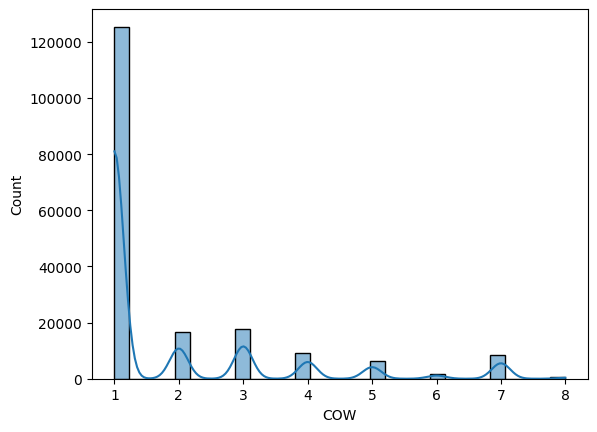

In [49]:

sns.histplot(df["COW"], kde=True, bins=30)
plt.show()


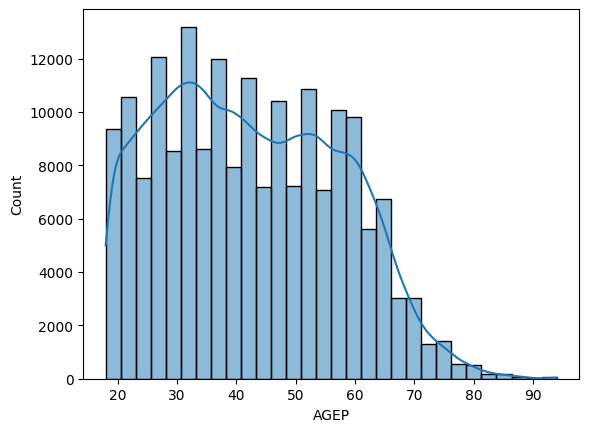

In [51]:
sns.histplot(df["AGEP"], kde=True, bins=30)
plt.show()

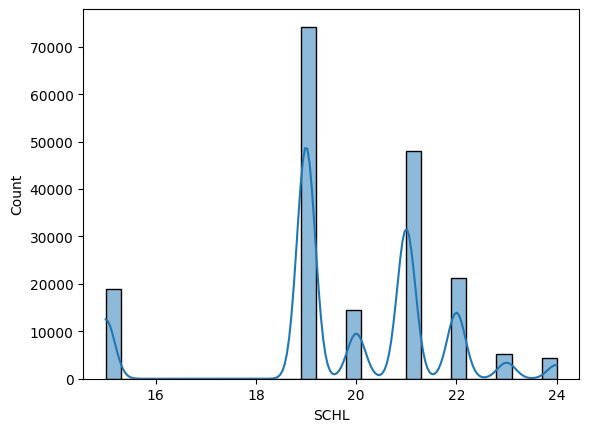

In [52]:
sns.histplot(df["SCHL"], kde=True, bins=30)
plt.show()

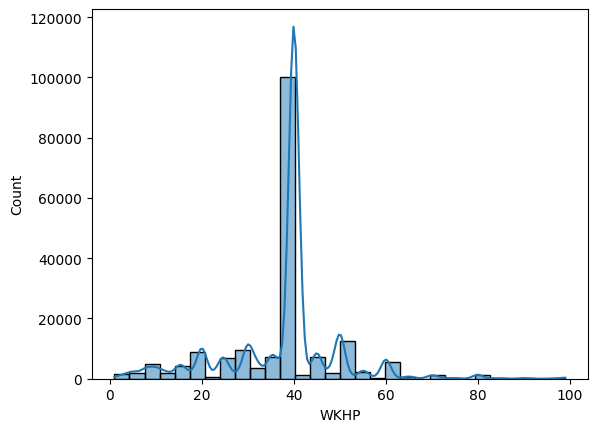

In [54]:
sns.histplot(df["WKHP"], kde=True, bins=30)
plt.show()

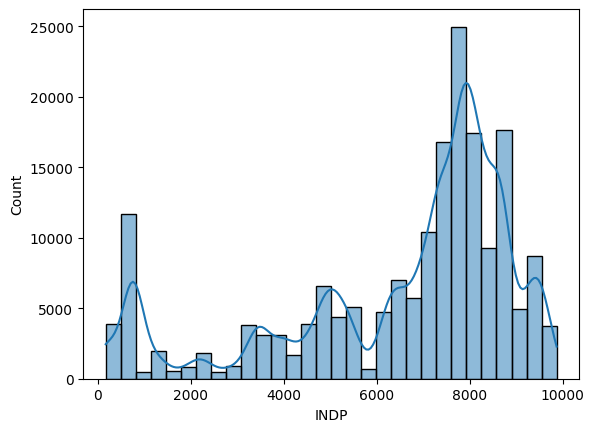

In [55]:
sns.histplot(df["INDP"], kde=True, bins=30)
plt.show()

# Based on skewness apply log tranformation to top 3 features and look at results

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['OCCP_AGE'] = dfStack['OCCP'] * dfStack['AGEP']
dfStack['WKHP_AGE'] = dfStack['WKHP'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
dfStack['INDP_OCCP'] = dfStack['INDP'] * dfStack['OCCP']
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X["COW"] = np.log1p(X["COW"])
X["RACE"] = np.log1p(X["RACE"])
X["OCCP_AGE"] = np.log1p(X["OCCP_AGE"])
X["INDP_OCCP"] = np.log1p(X["INDP_OCCP"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  
    learning_rate=0.006,  
    max_depth=9,  
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.007,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 14
[LightGBM] [Info] Start training from score 62194.269174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Blended Model R-squared Score: 0.6258


# Applying log transform does not help. Are the skewed features even helpful?

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
dfStack['SCHL_AGE'] = dfStack['SCHL'] * dfStack['AGEP']
dfStack['INDP_AGE'] = dfStack['INDP'] * dfStack['AGEP']
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR', 'COW', 'RACE'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  
    learning_rate=0.006,  
    max_depth=9, 
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05,  
    reg_lambda=0.05, 
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.007,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 9
[LightGBM] [Info] Start training from score 62194.269174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

# seem to be a bit helpful. try removing the added features but leave base ones

In [ ]:
from lightgbm import LGBMRegressor
dfStack = df_clean.copy()
y = dfStack['WAGP'] 
X = dfStack.drop(columns = ['WAGP', 'SCIENGRLP', 'ESR'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
xgb_model = XGBRegressor(
    n_estimators=5000,  
    learning_rate=0.006,  
    max_depth=9,  
    min_child_weight=3,  
    colsample_bytree=0.9,  
    subsample=0.8,  
    reg_alpha=0.05, 
    reg_lambda=0.05,  
    random_state=1234
)
# Define LGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.007,
    max_depth=9,
    num_leaves=50,
    colsample_bytree=0.9,
    subsample=0.9,
    min_child_samples=10,
    reg_alpha=0.05,
    reg_lambda=0.05,
    random_state=1234
)

# Train both models
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Blended prediction 
y_pred_blended = (0.52 * y_pred_xgb) + (0.48 * y_pred_lgbm)

# Evaluate
r2_blended = r2_score(y_test, y_pred_blended)
print(f"Blended Model R-squared Score: {r2_blended:.4f}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 143179, number of used features: 9
[LightGBM] [Info] Start training from score 62194.269174
Blended Model R-squared Score: 0.6286
